### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

2.10.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
------------------------------------------------------------------------------------------
[]
<function is_built_with_cuda at 0x000001EA833688B0>

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# Chapter 5: Machine learning k-fold cross-validation

ASSUMPTION --> run for datasets ESC-10, BDLib2 and US8K:

* *01_Feature_extraction_exploration.ipynb*
* *02_PreProcessing_and_ML_modeling.ipynb* 

And run for the new dataset US8K_AV:
* *03_New_dataset_US8K_AV.ipynb*

After that, run for all datasets:
* *04_ML_modeling.ipynb*

***

## Importe modules

In [2]:
import librosa
import os
import glob
import warnings
import mimetypes
import itertools
import time
import sys

import pandas  as pd
import seaborn as sns
import numpy   as np
from IPython.display import display

from matplotlib  import pyplot as plt

from tqdm                      import tqdm

from sklearn                   import metrics
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.linear_model      import LogisticRegression
from sklearn.naive_bayes       import GaussianNB
from sklearn.svm               import SVC
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import RandomForestClassifier, VotingClassifier
from sklearn.decomposition     import PCA
from sklearn.metrics           import classification_report

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '05_Machine_learning_cross_validation_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

# Loading the dataset


In [4]:
# Select the dataset

opc = 0
while str(opc) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")


    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = '1'

    pkl_features           = 'ESC-10_features_original.pkl'
    pkl_aug_features      = 'ESC-10_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'ESC-10_features_augmented.pkl'

    
if opc == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'

    pkl_features          = 'BDLib2_features_original.pkl'
    pkl_aug_features      = 'BDLib2_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'BDLib2_features_augmented.pkl'

    
if opc == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    
    pkl_features          = 'US8K_features_original.pkl'
    pkl_aug_features      = 'US8K_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    

if opc == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'

    pkl_features          = 'US8K_AV_features_original.pkl'
    pkl_aug_features      = 'US8K_AV_features_augmented_no_windowing.pkl'
    pkl_aug_wind_features = 'US8K_AV_features_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV



Select the dataset:  3


In [5]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [6]:
from MT_loadDataset import loadDataset

In [7]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


CSV exported.
Check the folder :  C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K

Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

Total number of unique files..........:  8732
Total number of AUDIO files...........:  8732


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,...,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",dog_bark,100032-3-0-0.wav,...,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-117.wav,...,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-121.wav,...,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-126.wav,...,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",children_playing,100263-2-0-137.wav,...,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
8727,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-2-0.wav,...,1,99812,159.522205,163.522205,2
8728,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-3-0.wav,...,1,99812,181.142431,183.284976,2
8729,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-4-0.wav,...,1,99812,242.691902,246.197885,2
8730,7,fold7,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",car_horn,99812-1-5-0.wav,...,1,99812,253.209850,255.741948,2


In [8]:
DB.dtypes

Fold                   int64
Folder_name           object
Class_OHEV            object
Class_categorical     object
File_name             object
Path                  object
classID                int64
fsID                   int64
start                float64
end                  float64
salience               int64
dtype: object

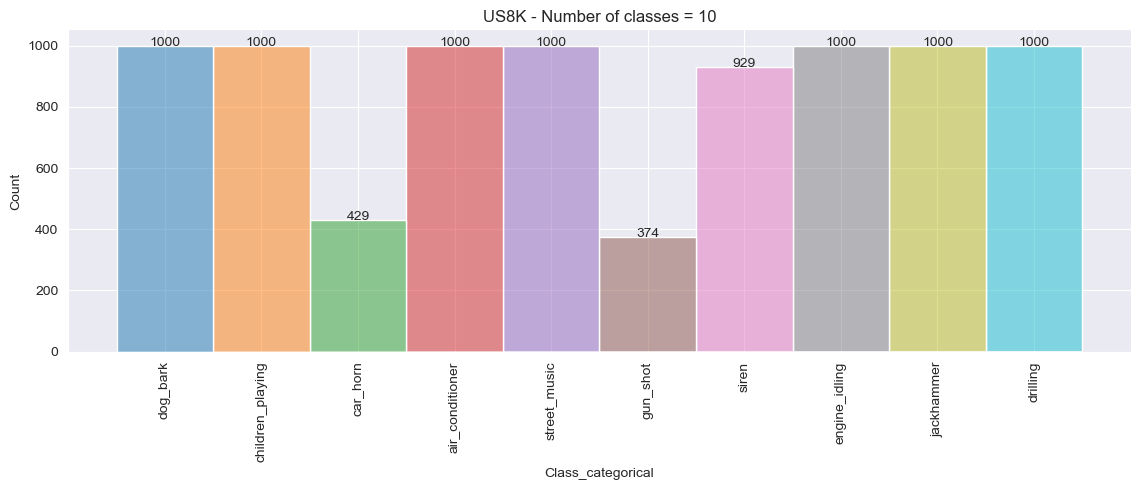

In [9]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [10]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_features))
    model_surname = '_original'

if opc == 2:
    DB_from_pkl   = pd.read_pickle(os.path.join(path_models, pkl_aug_features))
    model_surname = '_augmented'

if opc == 3:
    DB_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
    model_surname = '_windowed'


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K only windowed)



Select the dataset:  3


In [11]:
DB_from_pkl.dtypes

Audio                  object
Class_categorical      object
Class_OHEV             object
Fold                   object
RMSE                  float64
                       ...   
TONNETZ_6             float64
TONNETZ_std_6         float64
TONNETZ_median_6      float64
TONNETZ_skew_6        float64
TONNETZ_kurtosis_6    float64
Length: 379, dtype: object

In [12]:
total_duration = 0
for audio in DB_from_pkl['Audio']:
    total_duration = total_duration + librosa.get_duration(y=audio)
print('Total duration of the dataset: ' , "{:0.4f} h".format(total_duration / 3600))

Total duration of the dataset:  16.9527 h


In [13]:
DB_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,RMSE,...,TONNETZ_6,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.117183,...,-0.046177,0.025644,-0.046785,0.461191,-0.338882
1,"[-0.015428771, -0.0064468235, -0.002025701, -0.009768408, -0.020482529, -0.03246226, -0.046539657, -0.050950672, -0....",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.111724,...,-0.026347,0.026433,-0.030688,0.414979,-0.840459
2,"[-0.17165461, -0.1961453, -0.2095497, -0.116395764, 0.02499168, 0.15181583, 0.2456393, 0.24304995, 0.1697193, 0.0706...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.124646,...,-0.045096,0.023640,-0.045384,0.629947,0.096665
3,"[-0.004147315, -0.014180049, -0.016550057, -0.017083425, -0.010863152, -0.0018686495, 0.006234308, 0.00725661, 0.005...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.110741,...,-0.020052,0.024617,-0.025407,0.554764,-0.364067
4,"[-0.047271818, -0.08598116, -0.08329079, -0.15244874, -0.21367016, -0.26584676, -0.19677721, -0.17195633, -0.0841544...",dog_bark,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",5,0.125728,...,-0.032483,0.024934,-0.036388,0.770805,0.232676
...,...,...,...,...,...,...,...,...,...,...,...
61119,"[-0.024376377, -0.010054192, 0.0009410139, 0.005863713, -0.0005189497, -0.0021953415, 0.0013682423, -0.0043018945, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.012771,...,-0.066230,0.033488,-0.069738,0.175013,-0.974133
61120,"[0.0066777063, 0.008175363, 0.006157635, 0.0026387093, 0.00059039844, 0.0030925209, 0.0033645788, 0.0056151543, 0.00...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.007954,...,-0.022097,0.021007,-0.018432,-0.690702,-0.099409
61121,"[-0.0020232266, 0.001032982, 0.0023606261, 0.0017964527, 0.0009908059, -0.0011728329, -0.003362489, -0.0054453667, -...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.008383,...,-0.013611,0.021124,-0.016391,-0.028383,-1.071243
61122,"[-0.0015619812, 0.0005301243, 0.0032789772, 0.002725502, 0.0023546133, -0.0019822496, -0.002666029, -0.004454969, -0...",car_horn,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",7,0.010459,...,-0.012274,0.027106,-0.017513,-0.121982,-0.606880


In [14]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
air_conditioner    21862    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
car_horn           53318    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
children_playing   51965    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
dog_bark           21233    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
drilling           52240    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
engine_idling      8304     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
gun_shot           43257    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
jackhammer         13713    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
siren              54022    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
street_music       59007    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'air_conditioner': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 'drilling': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'engine_idling': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 'gun_shot': array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'jackhammer': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 'siren': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
 'street_music': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])}

In [15]:
nom_classes = list(encoder_dict.keys())
nom_classes

['air_conditioner',
 'car_horn',
 'children_playing',
 'dog_bark',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren',
 'street_music']

## ML Modeling

In [16]:
def get_mutual_info (X: list, X_val: list, X_norm: list, y: list):
    
    mutual_info = mutual_info_classif(X_norm, y)
    mutual_info = pd.Series(mutual_info)
    
    threshold = np.mean(mutual_info.sort_values(ascending=False))
    print(f' Threshold: {threshold}')
    
    count_mutual = sum(1 for element in mutual_info if element > threshold)
    print(f' Count mutual: {count_mutual}\n')
    
    chi2_selector    = SelectKBest(chi2, k=count_mutual).fit(X_norm, y)
    mutual_idx_train = chi2_selector.get_support(1)
    
    X_mutual     = X[X.columns[mutual_idx_train]] # final features
    X_val_mutual = X_val[X_val.columns[mutual_idx_train]] # final features

    print(f'X_train_mutual...: {X_mutual.shape}')
    print(f'X_val_mutual.....: {X_val_mutual.shape}\n')

    return X_mutual, X_val_mutual

In [17]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

In [18]:
# Pipeline to run the classifiers and their metrics using k-fold stratification according to the dataset specification

def model_classifiers(db: pd.DataFrame, 
                      scalerOpt: str, 
                      use_PCA = False,
                      use_mutual = False):
    
    if use_PCA:
        p = 2
    else:
        p = 1
    
    classifiers = ['Naïve Bayes', 'SVC', 'LogisticR', 'KNN', 'Forest', 'Voting']
    
    
    NB_c          = GaussianNB()
    SVC_c         = SVC(kernel = 'linear', C = 0.5, probability = True, random_state = SEED)
    LogisticR_c   = LogisticRegression(solver = 'saga', max_iter = 500, C = 0.5, n_jobs = -1)
    KNN_c         = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = p, leaf_size = 20, n_jobs = -1)
    forest_c      = RandomForestClassifier(n_estimators = 500, criterion = 'gini',bootstrap = True, n_jobs = -1)
    voting_c      = VotingClassifier(estimators = [(classifiers[0], NB_c),
                                                   (classifiers[1], SVC_c),
                                                   (classifiers[2], LogisticR_c),
                                                   (classifiers[3], KNN_c)],
                                     voting = 'soft')
    
    dic_classifiers = {'GaussianNB': NB_c, 
                       'SVC': SVC_c, 
                       'LogisticR' : LogisticR_c, 
                       'KNN': KNN_c, 
                       'Forest': forest_c, 
                       'Voting': voting_c}

    count       = 1
    ratio       = []
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Validation)',
                                                    'F1(Train)',
                                                    'F1(Validation)', 
                                                    'Precision(Train)',
                                                    'Precision(Validation)', 
                                                    'Recall(Train)',
                                                    'Recall(Validation)', 
                                                    'Conf_M',
                                                    'Process_time'])
    
    for fold in np.unique(db['Fold']):
        print(f"Validation fold: {fold}")
    
        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]
        
        X      = DB_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())

        X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

        X_mean   = X_statistics.values[:, 0]
        X_std    = X_statistics.values[:, 1]
        X_min    = X_statistics.values[:, 2]
        X_max    = X_statistics.values[:, 3]
        
        if scalerOpt == "normalization":
            X_train_norm = (X.values - X_min) / (X_max - X_min)
            X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
            batch_type    = '_norm'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        elif scalerOpt == "standardization":
            X_train_norm = (X.values - X_mean) / X_std
            X_val_norm   = (X_val.values - X_mean) / X_std
            batch_type    = '_std'
            print(f'X_train_norm shape...:{X_train_norm.shape}')
            print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
        else:
            sys.exit()
            
        if use_mutual:
            if scalerOpt == "standardization":
                print(f'Mutual information requires normalization!')
                sys.exit()
            else:
                X_train_norm, X_val_norm = get_mutual_info(X, X_val, X_train_norm, y)
                classifiers = ['Forest']
                dic_classifiers = {'Forest': forest_c}
                batch_type    = batch_type + '_mutual'
   
        if use_PCA:
            pcaT = PCA()
            pcaT.fit(X_train_norm)
            ratio = pcaT.explained_variance_ratio_
            
            batch_type = batch_type + '_PCA'
            
            T           = 0.98
            current_sum = 0
            countComp   = 0

            for element in ratio:
                current_sum += element
                countComp   += 1

                if current_sum >= T:
                    break

            # Print the result
            print(f'Sum of elements............: {current_sum}')
            print(f'Number of elements summed..: {countComp}\n')           
            
            pca          = PCA(n_components = countComp)
            X_train_norm = pca.fit_transform(X_train_norm)
            X_val_norm   = pca.transform(X_val_norm)
            
        for c in tqdm(dic_classifiers.items()):
            
            name         = c[0]
            model_name   = ('Model_' + c[0] + '_' + str(count))
            count        = count + 1
            model        = c[1]
            print(name)
            print(model)
            print(np.shape(X_train_norm))
            
            # Fitting the model to the classifier
            model.fit(X_train_norm, y)

            # Get the model predictions
            y_train_predicted = model.predict(X_train_norm)
            
            t_srt             = time.process_time_ns()
            y_val_predicited  = model.predict(X_val_norm)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)

            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val,  y_val_predicited)

            f1_Score_train = metrics.f1_score(y, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val,  y_val_predicited, average = 'weighted')

            precision_score_train = metrics.precision_score(y, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val,  y_val_predicited, average = 'weighted')

            recall_score_train = metrics.recall_score(y, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val,  y_val_predicited, average = 'weighted')

            class_report_val = classification_report(y_val, y_val_predicited)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val, y_val_predicited)

            # Store the name, validation accuracy results and model
            models.append((name, accuracy_val, model))
            
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Validation)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Validation)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Validation)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Validation)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time]})], ignore_index = True)
                   
    return acc_set, models, ratio, batch_type

In [ ]:
# Option for scalerOpt is either "normalization" or "standardization"

# PCA with mutual is ilogical, results will be useless
# Mutual does not work with negative numbers, therefore "standardization" returns an error
# Mutual will trigger only Random Forest

metrics_set, models_set,  ratio, batch_name = model_classifiers(DB_from_pkl,
                                                                scalerOpt = 'standardization',
                                                                use_PCA = True,
                                                                use_mutual = False)

Validation fold: 1
X_train_norm shape...:(55013, 375)
X_val_norm shape.....:(6111, 375)

Sum of elements............: 0.9803541013471814
Number of elements summed..: 241



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(55013, 241)


 17%|██████████████                                                                      | 1/6 [00:03<00:15,  3.05s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.25      0.26      0.26       700
        car_horn       0.17      0.44      0.25       252
children_playing       0.39      0.73      0.51       700
        dog_bark       0.49      0.39      0.44       700
        drilling       0.63      0.19      0.29       700
   engine_idling       0.37      0.19      0.26       672
        gun_shot       0.60      0.38      0.47       245
      jackhammer       0.57      0.83      0.68       840
           siren       0.30      0.22      0.25       602
    street_music       0.39      0.25      0.31       700

        accuracy                           0.40      6111
       macro avg       0.42      0.39      0.37      6111
    weighted avg       0.43      0.40      0.38      6111

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(55013, 241)


 33%|██████████████████████████▋                                                     | 2/6 [30:02<1:10:40, 1060.01s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.53      0.37      0.43       700
        car_horn       0.61      0.87      0.72       252
children_playing       0.59      0.78      0.67       700
        dog_bark       0.61      0.76      0.68       700
        drilling       0.50      0.56      0.53       700
   engine_idling       0.53      0.55      0.54       672
        gun_shot       0.91      0.80      0.85       245
      jackhammer       0.62      0.30      0.40       840
           siren       0.72      0.67      0.70       602
    street_music       0.59      0.66      0.62       700

        accuracy                           0.60      6111
       macro avg       0.62      0.63      0.61      6111
    weighted avg       0.60      0.60      0.58      6111

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(55013, 241)


 50%|█████████████████████████████████████████▌                                         | 3/6 [36:21<37:25, 748.62s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.63      0.41      0.50       700
        car_horn       0.69      0.86      0.77       252
children_playing       0.62      0.77      0.69       700
        dog_bark       0.72      0.76      0.74       700
        drilling       0.49      0.49      0.49       700
   engine_idling       0.62      0.56      0.59       672
        gun_shot       0.66      0.91      0.76       245
      jackhammer       0.69      0.57      0.62       840
           siren       0.71      0.71      0.71       602
    street_music       0.56      0.65      0.60       700

        accuracy                           0.63      6111
       macro avg       0.64      0.67      0.65      6111
    weighted avg       0.63      0.63      0.63      6111

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(55013, 241)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [36:42<15:23, 461.68s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.21      0.16      0.18       700
        car_horn       0.70      0.81      0.75       252
children_playing       0.43      0.77      0.55       700
        dog_bark       0.52      0.61      0.56       700
        drilling       0.48      0.50      0.49       700
   engine_idling       0.52      0.38      0.44       672
        gun_shot       0.88      0.91      0.89       245
      jackhammer       0.34      0.24      0.28       840
           siren       0.78      0.71      0.75       602
    street_music       0.69      0.54      0.61       700

        accuracy                           0.51      6111
       macro avg       0.55      0.56      0.55      6111
    weighted avg       0.51      0.51      0.50      6111

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(55013, 241)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [41:48<06:45, 405.42s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.50      0.19      0.28       700
        car_horn       0.81      0.75      0.78       252
children_playing       0.56      0.75      0.64       700
        dog_bark       0.57      0.79      0.66       700
        drilling       0.54      0.64      0.59       700
   engine_idling       0.63      0.51      0.57       672
        gun_shot       0.93      0.75      0.83       245
      jackhammer       0.59      0.52      0.55       840
           siren       0.82      0.79      0.81       602
    street_music       0.65      0.72      0.68       700

        accuracy                           0.62      6111
       macro avg       0.66      0.64      0.64      6111
    weighted avg       0.62      0.62      0.61      6111

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
     

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:18:41<00:00, 786.87s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.44      0.28      0.34       700
        car_horn       0.70      0.89      0.78       252
children_playing       0.52      0.85      0.65       700
        dog_bark       0.67      0.72      0.69       700
        drilling       0.56      0.55      0.55       700
   engine_idling       0.70      0.47      0.56       672
        gun_shot       0.89      0.91      0.90       245
      jackhammer       0.58      0.59      0.59       840
           siren       0.71      0.68      0.70       602
    street_music       0.68      0.60      0.64       700

        accuracy                           0.62      6111
       macro avg       0.65      0.66      0.64      6111
    weighted avg       0.62      0.62      0.61      6111

Validation fold: 10


X_train_norm shape...:(55265, 375)
X_val_norm shape.....:(5859, 375)

Sum of elements............: 0.9800512129496242
Number of elements summed..: 244



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(55265, 244)


 17%|██████████████                                                                      | 1/6 [00:02<00:14,  2.88s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.22      0.36      0.27       700
        car_horn       0.23      0.39      0.29       231
children_playing       0.35      0.59      0.44       700
        dog_bark       0.50      0.39      0.44       700
        drilling       0.66      0.16      0.26       700
   engine_idling       0.49      0.10      0.17       651
        gun_shot       0.71      0.67      0.69       224
      jackhammer       0.42      0.91      0.58       672
           siren       0.65      0.16      0.26       581
    street_music       0.54      0.39      0.45       700

        accuracy                           0.40      5859
       macro avg       0.48      0.41      0.38      5859
    weighted avg       0.47      0.40      0.37      5859

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(55265, 244)


 33%|██████████████████████████▋                                                     | 2/6 [35:32<1:23:35, 1253.85s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.67      0.60      0.63       700
        car_horn       0.71      0.66      0.68       231
children_playing       0.54      0.83      0.65       700
        dog_bark       0.71      0.69      0.70       700
        drilling       0.68      0.68      0.68       700
   engine_idling       0.70      0.67      0.69       651
        gun_shot       0.83      0.90      0.86       224
      jackhammer       0.85      0.75      0.79       672
           siren       0.72      0.47      0.57       581
    street_music       0.75      0.76      0.76       700

        accuracy                           0.69      5859
       macro avg       0.71      0.70      0.70      5859
    weighted avg       0.71      0.69      0.69      5859

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(55265, 244)


 50%|█████████████████████████████████████████▌                                         | 3/6 [43:15<44:38, 892.77s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.68      0.63      0.66       700
        car_horn       0.85      0.68      0.76       231
children_playing       0.57      0.78      0.66       700
        dog_bark       0.75      0.69      0.72       700
        drilling       0.68      0.63      0.65       700
   engine_idling       0.66      0.69      0.68       651
        gun_shot       0.96      0.89      0.92       224
      jackhammer       0.70      0.80      0.75       672
           siren       0.72      0.50      0.59       581
    street_music       0.76      0.78      0.77       700

        accuracy                           0.70      5859
       macro avg       0.73      0.71      0.71      5859
    weighted avg       0.71      0.70      0.70      5859

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(55265, 244)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [43:42<18:21, 550.91s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.49      0.71      0.58       700
        car_horn       0.53      0.51      0.52       231
children_playing       0.37      0.79      0.51       700
        dog_bark       0.75      0.54      0.63       700
        drilling       0.62      0.37      0.47       700
   engine_idling       0.79      0.52      0.63       651
        gun_shot       0.84      0.88      0.86       224
      jackhammer       0.54      0.51      0.52       672
           siren       0.59      0.41      0.48       581
    street_music       0.77      0.58      0.66       700

        accuracy                           0.57      5859
       macro avg       0.63      0.58      0.58      5859
    weighted avg       0.62      0.57      0.57      5859

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(55265, 244)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [48:49<07:42, 462.96s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.76      0.78      0.77       700
        car_horn       0.80      0.54      0.64       231
children_playing       0.46      0.82      0.59       700
        dog_bark       0.82      0.68      0.74       700
        drilling       0.57      0.58      0.58       700
   engine_idling       0.87      0.71      0.78       651
        gun_shot       0.91      0.84      0.87       224
      jackhammer       0.70      0.65      0.68       672
           siren       0.73      0.44      0.55       581
    street_music       0.73      0.76      0.75       700

        accuracy                           0.68      5859
       macro avg       0.74      0.68      0.70      5859
    weighted avg       0.72      0.68      0.69      5859

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
     

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:27:35<00:00, 875.99s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.66      0.73      0.69       700
        car_horn       0.81      0.67      0.73       231
children_playing       0.50      0.87      0.63       700
        dog_bark       0.85      0.67      0.75       700
        drilling       0.85      0.61      0.71       700
   engine_idling       0.80      0.58      0.67       651
        gun_shot       0.96      0.94      0.95       224
      jackhammer       0.66      0.93      0.77       672
           siren       0.80      0.45      0.58       581
    street_music       0.78      0.73      0.75       700

        accuracy                           0.71      5859
       macro avg       0.77      0.72      0.72      5859
    weighted avg       0.75      0.71      0.71      5859

Validation fold: 2


X_train_norm shape...:(54908, 375)
X_val_norm shape.....:(6216, 375)

Sum of elements............: 0.9802930008337611
Number of elements summed..: 244



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(54908, 244)


 17%|██████████████                                                                      | 1/6 [00:02<00:13,  2.78s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.27      0.66      0.39       700
        car_horn       0.15      0.17      0.16       294
children_playing       0.36      0.63      0.45       700
        dog_bark       0.60      0.40      0.48       700
        drilling       0.47      0.08      0.14       700
   engine_idling       0.13      0.06      0.09       700
        gun_shot       0.54      0.61      0.57       245
      jackhammer       0.53      0.58      0.56       840
           siren       0.54      0.27      0.36       637
    street_music       0.29      0.21      0.24       700

        accuracy                           0.37      6216
       macro avg       0.39      0.37      0.34      6216
    weighted avg       0.39      0.37      0.34      6216

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(54908, 244)


 33%|██████████████████████████▋                                                     | 2/6 [30:10<1:10:58, 1064.61s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.52      0.48      0.50       700
        car_horn       0.58      0.73      0.65       294
children_playing       0.54      0.75      0.63       700
        dog_bark       0.82      0.74      0.78       700
        drilling       0.70      0.65      0.67       700
   engine_idling       0.32      0.49      0.39       700
        gun_shot       0.86      0.96      0.91       245
      jackhammer       0.44      0.17      0.24       840
           siren       0.89      0.75      0.82       637
    street_music       0.67      0.71      0.69       700

        accuracy                           0.60      6216
       macro avg       0.64      0.64      0.63      6216
    weighted avg       0.62      0.60      0.60      6216

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(54908, 244)


 50%|█████████████████████████████████████████▌                                         | 3/6 [36:09<37:07, 742.37s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.55      0.59      0.57       700
        car_horn       0.74      0.60      0.66       294
children_playing       0.59      0.75      0.66       700
        dog_bark       0.82      0.76      0.79       700
        drilling       0.67      0.65      0.66       700
   engine_idling       0.32      0.50      0.39       700
        gun_shot       0.73      0.90      0.81       245
      jackhammer       0.63      0.20      0.30       840
           siren       0.88      0.72      0.79       637
    street_music       0.60      0.71      0.65       700

        accuracy                           0.61      6216
       macro avg       0.65      0.64      0.63      6216
    weighted avg       0.64      0.61      0.60      6216

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(54908, 244)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [36:29<15:14, 457.10s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.34      0.55      0.42       700
        car_horn       0.30      0.31      0.30       294
children_playing       0.39      0.74      0.51       700
        dog_bark       0.75      0.62      0.68       700
        drilling       0.77      0.45      0.57       700
   engine_idling       0.23      0.16      0.19       700
        gun_shot       0.83      0.87      0.85       245
      jackhammer       0.38      0.28      0.32       840
           siren       0.68      0.50      0.58       637
    street_music       0.60      0.53      0.56       700

        accuracy                           0.48      6216
       macro avg       0.53      0.50      0.50      6216
    weighted avg       0.51      0.48      0.48      6216

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(54908, 244)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [41:18<06:36, 396.49s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.62      0.49      0.55       700
        car_horn       0.74      0.23      0.35       294
children_playing       0.54      0.84      0.66       700
        dog_bark       0.76      0.76      0.76       700
        drilling       0.67      0.58      0.62       700
   engine_idling       0.39      0.38      0.39       700
        gun_shot       0.76      0.91      0.83       245
      jackhammer       0.62      0.59      0.60       840
           siren       0.80      0.51      0.62       637
    street_music       0.52      0.73      0.60       700

        accuracy                           0.60      6216
       macro avg       0.64      0.60      0.60      6216
    weighted avg       0.62      0.60      0.60      6216

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
     

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:17:43<00:00, 777.27s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.47      0.66      0.55       700
        car_horn       0.74      0.50      0.60       294
children_playing       0.51      0.79      0.62       700
        dog_bark       0.87      0.72      0.79       700
        drilling       0.80      0.61      0.70       700
   engine_idling       0.28      0.31      0.30       700
        gun_shot       0.72      0.94      0.82       245
      jackhammer       0.62      0.43      0.51       840
           siren       0.89      0.61      0.72       637
    street_music       0.61      0.65      0.63       700

        accuracy                           0.60      6216
       macro avg       0.65      0.62      0.62      6216
    weighted avg       0.64      0.60      0.61      6216

Validation fold: 3


X_train_norm shape...:(54649, 375)
X_val_norm shape.....:(6475, 375)

Sum of elements............: 0.9801863114238477
Number of elements summed..: 244



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(54649, 244)


 17%|██████████████                                                                      | 1/6 [00:02<00:12,  2.59s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.17      0.30      0.22       700
        car_horn       0.55      0.90      0.69       301
children_playing       0.33      0.64      0.43       700
        dog_bark       0.68      0.36      0.47       700
        drilling       0.79      0.33      0.47       700
   engine_idling       0.08      0.02      0.04       749
        gun_shot       0.78      0.74      0.76       252
      jackhammer       0.44      0.84      0.57       840
           siren       0.70      0.22      0.33       833
    street_music       0.30      0.16      0.21       700

        accuracy                           0.40      6475
       macro avg       0.48      0.45      0.42      6475
    weighted avg       0.46      0.40      0.38      6475

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(54649, 244)


 33%|███████████████████████████▋                                                       | 2/6 [24:51<58:26, 876.62s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.22      0.17      0.19       700
        car_horn       0.68      0.95      0.79       301
children_playing       0.61      0.69      0.64       700
        dog_bark       0.60      0.70      0.64       700
        drilling       0.64      0.58      0.61       700
   engine_idling       0.53      0.33      0.41       749
        gun_shot       0.87      0.95      0.91       252
      jackhammer       0.54      0.65      0.59       840
           siren       0.76      0.76      0.76       833
    street_music       0.59      0.56      0.57       700

        accuracy                           0.59      6475
       macro avg       0.60      0.63      0.61      6475
    weighted avg       0.58      0.59      0.58      6475

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(54649, 244)


 50%|█████████████████████████████████████████▌                                         | 3/6 [29:56<30:47, 615.77s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.19      0.13      0.16       700
        car_horn       0.75      0.94      0.83       301
children_playing       0.61      0.67      0.64       700
        dog_bark       0.64      0.67      0.65       700
        drilling       0.73      0.62      0.67       700
   engine_idling       0.47      0.36      0.41       749
        gun_shot       0.82      0.91      0.86       252
      jackhammer       0.52      0.74      0.61       840
           siren       0.74      0.74      0.74       833
    street_music       0.57      0.54      0.56       700

        accuracy                           0.59      6475
       macro avg       0.60      0.63      0.61      6475
    weighted avg       0.58      0.59      0.58      6475

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(54649, 244)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [30:13<12:39, 379.53s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.21      0.41      0.28       700
        car_horn       0.72      0.92      0.81       301
children_playing       0.46      0.78      0.58       700
        dog_bark       0.77      0.54      0.64       700
        drilling       0.55      0.60      0.57       700
   engine_idling       0.19      0.09      0.12       749
        gun_shot       0.94      0.98      0.96       252
      jackhammer       0.43      0.30      0.35       840
           siren       0.85      0.61      0.71       833
    street_music       0.58      0.43      0.49       700

        accuracy                           0.51      6475
       macro avg       0.57      0.57      0.55      6475
    weighted avg       0.54      0.51      0.50      6475

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(54649, 244)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [34:39<05:38, 338.43s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.33      0.19      0.24       700
        car_horn       0.94      0.91      0.93       301
children_playing       0.58      0.75      0.65       700
        dog_bark       0.71      0.67      0.69       700
        drilling       0.63      0.70      0.66       700
   engine_idling       0.47      0.22      0.30       749
        gun_shot       0.96      0.94      0.95       252
      jackhammer       0.52      0.84      0.64       840
           siren       0.85      0.68      0.75       833
    street_music       0.52      0.60      0.56       700

        accuracy                           0.61      6475
       macro avg       0.65      0.65      0.64      6475
    weighted avg       0.61      0.61      0.60      6475

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
     

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:05:11<00:00, 651.96s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.23      0.26      0.24       700
        car_horn       0.88      0.99      0.93       301
children_playing       0.52      0.79      0.62       700
        dog_bark       0.77      0.61      0.68       700
        drilling       0.90      0.66      0.76       700
   engine_idling       0.49      0.21      0.29       749
        gun_shot       0.94      0.98      0.96       252
      jackhammer       0.51      0.85      0.63       840
           siren       0.88      0.68      0.77       833
    street_music       0.59      0.49      0.54       700

        accuracy                           0.61      6475
       macro avg       0.67      0.65      0.64      6475
    weighted avg       0.64      0.61      0.60      6475

Validation fold: 4


X_train_norm shape...:(54194, 375)
X_val_norm shape.....:(6930, 375)

Sum of elements............: 0.9800724681395293
Number of elements summed..: 246



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(54194, 246)


 17%|██████████████                                                                      | 1/6 [00:02<00:12,  2.49s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.35      0.48      0.41       700
        car_horn       0.10      0.10      0.10       413
children_playing       0.29      0.66      0.40       700
        dog_bark       0.60      0.40      0.48       700
        drilling       0.61      0.09      0.15       700
   engine_idling       0.03      0.01      0.02       749
        gun_shot       0.67      0.64      0.66       266
      jackhammer       0.32      0.75      0.45       840
           siren       0.65      0.21      0.32      1162
    street_music       0.19      0.15      0.17       700

        accuracy                           0.34      6930
       macro avg       0.38      0.35      0.31      6930
    weighted avg       0.39      0.34      0.30      6930

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(54194, 246)


 33%|███████████████████████████                                                      | 2/6 [25:48<1:00:42, 910.58s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.39      0.35      0.37       700
        car_horn       0.77      0.51      0.61       413
children_playing       0.59      0.58      0.59       700
        dog_bark       0.66      0.80      0.72       700
        drilling       0.50      0.63      0.56       700
   engine_idling       0.55      0.69      0.61       749
        gun_shot       0.92      0.78      0.84       266
      jackhammer       0.73      0.55      0.63       840
           siren       0.89      0.86      0.87      1162
    street_music       0.62      0.59      0.61       700

        accuracy                           0.64      6930
       macro avg       0.66      0.63      0.64      6930
    weighted avg       0.66      0.64      0.64      6930

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(54194, 246)


 50%|█████████████████████████████████████████▌                                         | 3/6 [30:57<31:46, 635.59s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.39      0.35      0.37       700
        car_horn       0.81      0.48      0.60       413
children_playing       0.66      0.58      0.62       700
        dog_bark       0.70      0.75      0.73       700
        drilling       0.64      0.71      0.68       700
   engine_idling       0.58      0.70      0.63       749
        gun_shot       0.84      0.80      0.82       266
      jackhammer       0.65      0.73      0.69       840
           siren       0.87      0.86      0.86      1162
    street_music       0.60      0.58      0.59       700

        accuracy                           0.67      6930
       macro avg       0.68      0.65      0.66      6930
    weighted avg       0.67      0.67      0.67      6930

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(54194, 246)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [31:15<13:04, 392.06s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.28      0.36      0.32       700
        car_horn       0.74      0.40      0.52       413
children_playing       0.29      0.65      0.41       700
        dog_bark       0.61      0.60      0.60       700
        drilling       0.55      0.51      0.53       700
   engine_idling       0.36      0.21      0.26       749
        gun_shot       0.87      0.81      0.84       266
      jackhammer       0.40      0.40      0.40       840
           siren       0.85      0.54      0.66      1162
    street_music       0.58      0.51      0.54       700

        accuracy                           0.48      6930
       macro avg       0.55      0.50      0.51      6930
    weighted avg       0.54      0.48      0.49      6930

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(54194, 246)


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [35:45<05:47, 347.78s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.40      0.19      0.26       700
        car_horn       0.98      0.36      0.52       413
children_playing       0.43      0.61      0.51       700
        dog_bark       0.67      0.76      0.71       700
        drilling       0.58      0.71      0.64       700
   engine_idling       0.37      0.29      0.33       749
        gun_shot       0.92      0.73      0.81       266
      jackhammer       0.40      0.61      0.48       840
           siren       0.90      0.75      0.82      1162
    street_music       0.60      0.65      0.63       700

        accuracy                           0.58      6930
       macro avg       0.63      0.57      0.57      6930
    weighted avg       0.60      0.58      0.57      6930

Voting
VotingClassifier(estimators=[('Naïve Bayes', GaussianNB()),
                             ('SVC',
                              SVC(C=0.5, kernel='linear', probability=True,
     

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:08:26<00:00, 684.41s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.43      0.37      0.40       700
        car_horn       0.89      0.45      0.60       413
children_playing       0.48      0.70      0.57       700
        dog_bark       0.74      0.71      0.73       700
        drilling       0.69      0.61      0.65       700
   engine_idling       0.58      0.48      0.53       749
        gun_shot       0.87      0.82      0.84       266
      jackhammer       0.48      0.78      0.59       840
           siren       0.90      0.75      0.82      1162
    street_music       0.65      0.53      0.59       700

        accuracy                           0.63      6930
       macro avg       0.67      0.62      0.63      6930
    weighted avg       0.66      0.63      0.63      6930

Validation fold: 5


X_train_norm shape...:(54572, 375)
X_val_norm shape.....:(6552, 375)

Sum of elements............: 0.9802060314654999
Number of elements summed..: 245



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

GaussianNB
GaussianNB()
(54572, 245)


 17%|██████████████                                                                      | 1/6 [00:02<00:12,  2.44s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.41      0.56      0.47       700
        car_horn       0.13      0.12      0.12       686
children_playing       0.38      0.65      0.48       700
        dog_bark       0.36      0.29      0.32       700
        drilling       0.10      0.03      0.05       700
   engine_idling       0.32      0.11      0.17       749
        gun_shot       0.76      0.82      0.79       280
      jackhammer       0.39      0.69      0.50       840
           siren       0.52      0.21      0.30       497
    street_music       0.32      0.31      0.32       700

        accuracy                           0.36      6552
       macro avg       0.37      0.38      0.35      6552
    weighted avg       0.34      0.36      0.33      6552

SVC
SVC(C=0.5, kernel='linear', probability=True, random_state=1000)
(54572, 245)


 33%|██████████████████████████▋                                                     | 2/6 [29:50<1:10:12, 1053.01s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.55      0.55      0.55       700
        car_horn       0.86      0.57      0.69       686
children_playing       0.59      0.68      0.63       700
        dog_bark       0.62      0.69      0.65       700
        drilling       0.52      0.59      0.55       700
   engine_idling       0.73      0.59      0.65       749
        gun_shot       0.86      0.91      0.88       280
      jackhammer       0.91      0.84      0.87       840
           siren       0.64      0.82      0.72       497
    street_music       0.76      0.77      0.76       700

        accuracy                           0.69      6552
       macro avg       0.70      0.70      0.70      6552
    weighted avg       0.70      0.69      0.69      6552

LogisticR
LogisticRegression(C=0.5, max_iter=500, n_jobs=-1, solver='saga')
(54572, 245)


 50%|█████████████████████████████████████████▌                                         | 3/6 [35:45<36:42, 734.04s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.65      0.68      0.66       700
        car_horn       0.86      0.50      0.63       686
children_playing       0.67      0.68      0.68       700
        dog_bark       0.66      0.69      0.68       700
        drilling       0.56      0.56      0.56       700
   engine_idling       0.70      0.63      0.67       749
        gun_shot       0.85      0.92      0.88       280
      jackhammer       0.81      0.92      0.86       840
           siren       0.71      0.85      0.77       497
    street_music       0.73      0.79      0.76       700

        accuracy                           0.71      6552
       macro avg       0.72      0.72      0.71      6552
    weighted avg       0.71      0.71      0.70      6552

KNN
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=3)
(54572, 245)


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [36:04<15:03, 451.83s/it]

                  precision    recall  f1-score   support

 air_conditioner       0.42      0.63      0.50       700
        car_horn       0.87      0.53      0.66       686
children_playing       0.43      0.72      0.54       700
        dog_bark       0.66      0.49      0.56       700
        drilling       0.53      0.31      0.39       700
   engine_idling       0.66      0.42      0.51       749
        gun_shot       0.87      0.93      0.90       280
      jackhammer       0.72      0.88      0.79       840
           siren       0.70      0.78      0.73       497
    street_music       0.62      0.57      0.59       700

        accuracy                           0.60      6552
       macro avg       0.65      0.62      0.62      6552
    weighted avg       0.63      0.60      0.60      6552

Forest
RandomForestClassifier(n_estimators=500, n_jobs=-1)
(54572, 245)


In [ ]:
batch_name

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [ ]:
metrics_set

In [ ]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Validation)'], ascending = [True, True]).reset_index()
metrics_set

In [ ]:
metrics_set[['Model', 'Accuracy(Validation)']].style.background_gradient(cmap = cmap_cm)

In [ ]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Validation)'].max()
highest_accuracy

In [ ]:
list_classifiers = metrics_set['Model'].unique().tolist()
list_classifiers

In [ ]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in list_classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [ ]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

In [ ]:
metrics_set_no_cm = metrics_set.drop('Conf_M', axis=1)
metrics_set_no_cm

In [ ]:
metrics_set_name       = nom_dataset + '_metrics_set' + batch_name +  model_surname + '.csv'
metrics_set_name_no_cm = nom_dataset + '_metrics_set' + batch_name +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

In [ ]:
# Writes de results to a CSV file

metrics_set.to_csv(os.path.join(path_models, metrics_set_name), sep='\t', encoding='utf-8')
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [ ]:
idx = metrics_set.groupby('Model')['Accuracy(Validation)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Validation)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

In [ ]:
conf_matrices_dict['LogisticR']['Conf_M']

In [ ]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Validation)'])
    print(conf_matrices_dict[i]['Conf_M'])

In [ ]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(25,25))
plt.suptitle('Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.97)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = nom_dataset + model_surname + batch_name + ' - Classifier '+ i + ' (Highest accuracy (Validation): ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Validation)'])) +')'
    plt.subplot(3,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)
plt.tight_layout(pad=4.0)
plt.savefig(os.path.join(path_pic, picture_name))

In [ ]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname + batch_name})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Validation)", showfliers = True)

medians = list(metrics_set.groupby(['Model'], sort = False)['Accuracy(Validation)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Validation)'].median()*0.001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

## Results ESC-10

## Results BDLib2

## Results US8K

## Results US8K_AV

# End of notebook